In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [2]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

np.random.seed(123)
merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

In [3]:
def calculate_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        "WAPE": np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    }

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type='lr'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if model_type == 'lr':
        model = LinearRegression()
    elif model_type == 'knn':
        model = KNeighborsRegressor(n_neighbors=6)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return calculate_metrics(y_test, y_pred)

def add_metadata(metrics, region, target, strategy, features_used, model_type):
    model_name = 'Linear Regression' if model_type == 'lr' else 'KNN'
    metrics.update({
        'Region': region,
        'Target': target,
        'Strategy': strategy,
        'Model': model_name,
        'Features Used': ', '.join(features_used)
    })
    return metrics

def reorder_columns(df):
    column_order = [
        'Region', 'Target', 'Strategy', 'Model', 'Features Used', 'Features Abbreviated',
        'MSE', 'R²', 'MAE', 'RMSE', 'MAPE', 'WAPE'
    ]
    existing_columns = df.columns.tolist()
    final_columns = [col for col in column_order if col in existing_columns]
    return df[final_columns]

def within_domain(df, features, target_columns, model_type):
    results = []
    for region in df['Region Grouped'].unique():
        region_data = df[df['Region Grouped'] == region].copy()
        mask = region_data['is_train'] == 1
        
        for target in target_columns:
            X_train = region_data[features][mask]
            X_test = region_data[features][~mask]
            y_train = region_data[target][mask]
            y_test = region_data[target][~mask]
            
            metrics = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type)
            results.append(add_metadata(metrics, region, target, 'Within-Domain', features, model_type))
    return reorder_columns(pd.DataFrame(results).round(2))

def cross_domain(df, features, target_columns, model_type):
    results = []
    regions = df['Region Grouped'].unique()
    
    for test_region in regions:
        train_data = df[(df['Region Grouped'] != test_region) & 
                       (df['is_train'] == 1)]
        test_data = df[(df['Region Grouped'] == test_region) & 
                      (df['is_train'] == 0)]
        
        for target in target_columns:
            X_train = train_data[features]
            X_test = test_data[features]
            y_train = train_data[target]
            y_test = test_data[target]
            
            metrics = train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type)
            results.append(add_metadata(metrics, test_region, target, 'Cross-Domain', features, model_type))
            
    return reorder_columns(pd.DataFrame(results).round(2))


def all_domain(df, features, target_columns, model_type):
    results = []
    regions = df['Region Grouped'].unique()
    
    train_mask = df['is_train'] == 1
    X_train_all = df[features][train_mask]
    
    for region in regions:
        test_mask = (df['Region Grouped'] == region) & (df['is_train'] == 0)
        test_data = df[test_mask]
        
        for target in target_columns:
            y_train = df[target][train_mask]
            y_test = test_data[target]
            X_test = test_data[features]
            
            metrics = train_and_evaluate_model(X_train_all, X_test, y_train, y_test, model_type)
            results.append(add_metadata(metrics, region, target, 'All-Domain', features, model_type))
    return reorder_columns(pd.DataFrame(results).round(2))

def add_abbreviated_feature_column(df, features, feature_abbreviations):
    abbreviated_features = [feature_abbreviations.get(feature, feature) for feature in features]
    df['Features Abbreviated'] = ' | '.join(abbreviated_features)
    return df

def append_total_row(df):
    total_row_df = pd.DataFrame()
    
    for target in df['Target'].unique():
        target_df = df[df['Target'] == target]
        metrics_avg = target_df[['MSE', 'R²', 'MAE', 'RMSE', 'MAPE', 'WAPE']].mean()
        
        total_row = {
            'Region': 'Total',
            'Target': target,
            'Strategy': df['Strategy'].iloc[0],
            'Model': df['Model'].iloc[0],
            'Features Used': df['Features Used'].iloc[0],
            'Features Abbreviated': df.get('Features Abbreviated', [''])[0],
            'MSE': metrics_avg['MSE'],
            'R²': metrics_avg['R²'],
            'MAE': metrics_avg['MAE'],
            'RMSE': metrics_avg['RMSE'],
            'MAPE': metrics_avg['MAPE'],
            'WAPE': metrics_avg['WAPE']
        }
        
        total_row_df = pd.concat([total_row_df, pd.DataFrame([total_row])], ignore_index=True)
    
    return reorder_columns(pd.concat([df, total_row_df], ignore_index=True))

def filter_and_concatenate(*dfs):
    filtered_dfs = [df[df['Region'] == 'Total'] for df in dfs]
    concatenated_df = pd.concat(filtered_dfs, ignore_index=True)
    return concatenated_df

def run_all_strategies(df, features, target_columns, model_type):
    within_domain_results = within_domain(df, features, target_columns, model_type)
    cross_domain_results = cross_domain(df, features, target_columns, model_type)
    all_domain_results = all_domain(df, features, target_columns, model_type)
    return within_domain_results, cross_domain_results, all_domain_results



In [4]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


In [5]:
# Linear Regression
within_domain_results_lr, cross_domain_results_lr, all_domain_results_lr = run_all_strategies(
    df=merged_df,
    features=features,
    target_columns=target_columns,
    model_type='lr'
)

# KNN
within_domain_results_knn, cross_domain_results_knn, all_domain_results_knn = run_all_strategies(
    df=merged_df,
    features=features,
    target_columns=target_columns,
    model_type='knn'
)

# Linear Regression
within_domain_results_lr = add_abbreviated_feature_column(within_domain_results_lr, features, feature_abbreviations)
cross_domain_results_lr = add_abbreviated_feature_column(cross_domain_results_lr, features, feature_abbreviations)
all_domain_results_lr = add_abbreviated_feature_column(all_domain_results_lr, features, feature_abbreviations)

within_domain_results_lr = append_total_row(within_domain_results_lr)
cross_domain_results_lr = append_total_row(cross_domain_results_lr)
all_domain_results_lr = append_total_row(all_domain_results_lr)

# KNN
within_domain_results_knn = add_abbreviated_feature_column(within_domain_results_knn, features, feature_abbreviations)
cross_domain_results_knn = add_abbreviated_feature_column(cross_domain_results_knn, features, feature_abbreviations)
all_domain_results_knn = add_abbreviated_feature_column(all_domain_results_knn, features, feature_abbreviations)

within_domain_results_knn = append_total_row(within_domain_results_knn)
cross_domain_results_knn = append_total_row(cross_domain_results_knn)
all_domain_results_knn = append_total_row(all_domain_results_knn)

# Concatenate results
concatenated_results_lr = filter_and_concatenate(
    within_domain_results_lr,
    cross_domain_results_lr,
    all_domain_results_lr
)

concatenated_results_knn = filter_and_concatenate(
    within_domain_results_knn,
    cross_domain_results_knn,
    all_domain_results_knn
)

In [6]:
concatenated_results_lr.sort_values(by=['Target', 'Strategy'], ascending=[True, False])


,Region,Target,Strategy,Model,Features Used,Features Abbreviated,MSE,R²,MAE,RMSE,MAPE,WAPE
1,Total,Non-residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,3067.808,-0.610,31.452,43.550,17.762,15.104
3,Total,Non-residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,5459.066,-10.970,55.872,63.752,32.468,31.576
5,Total,Non-residential EUI (kWh/m2/year),All-Domain,Linear Regression,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,3565.130,-2.206,40.778,48.102,21.460,20.524
0,Total,Residential EUI (kWh/m2/year),Within-Domain,Linear Regression,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1793.940,-0.080,23.676,33.578,20.356,17.716
2,Total,Residential EUI (kWh/m2/year),Cross-Domain,Linear Regression,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,2443.348,-3.336,40.340,47.638,40.770,35.654
4,Total,Residential EUI (kWh/m2/year),All-Domain,Linear Regression,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1458.518,-0.928,28.292,35.534,25.416,23.094


In [7]:
concatenated_results_knn.sort_values(by=['Target', 'Strategy'], ascending=[True, False])

,Region,Target,Strategy,Model,Features Used,Features Abbreviated,MSE,R²,MAE,RMSE,MAPE,WAPE
1,Total,Non-residential EUI (kWh/m2/year),Within-Domain,KNN,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1239.198,0.032,18.404,29.400,9.302,9.094
3,Total,Non-residential EUI (kWh/m2/year),Cross-Domain,KNN,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,4770.898,-11.720,45.986,58.572,23.908,23.174
5,Total,Non-residential EUI (kWh/m2/year),All-Domain,KNN,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1313.106,-0.182,19.598,30.832,10.122,9.876
0,Total,Residential EUI (kWh/m2/year),Within-Domain,KNN,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1028.244,0.330,21.128,27.438,15.874,15.686
2,Total,Residential EUI (kWh/m2/year),Cross-Domain,KNN,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1643.926,-3.360,32.590,39.924,31.946,29.876
4,Total,Residential EUI (kWh/m2/year),All-Domain,KNN,"hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Lat | Long | Paris | H...,1013.822,0.306,19.896,26.996,15.132,15.124


# Experiment: LR - Within Domain 

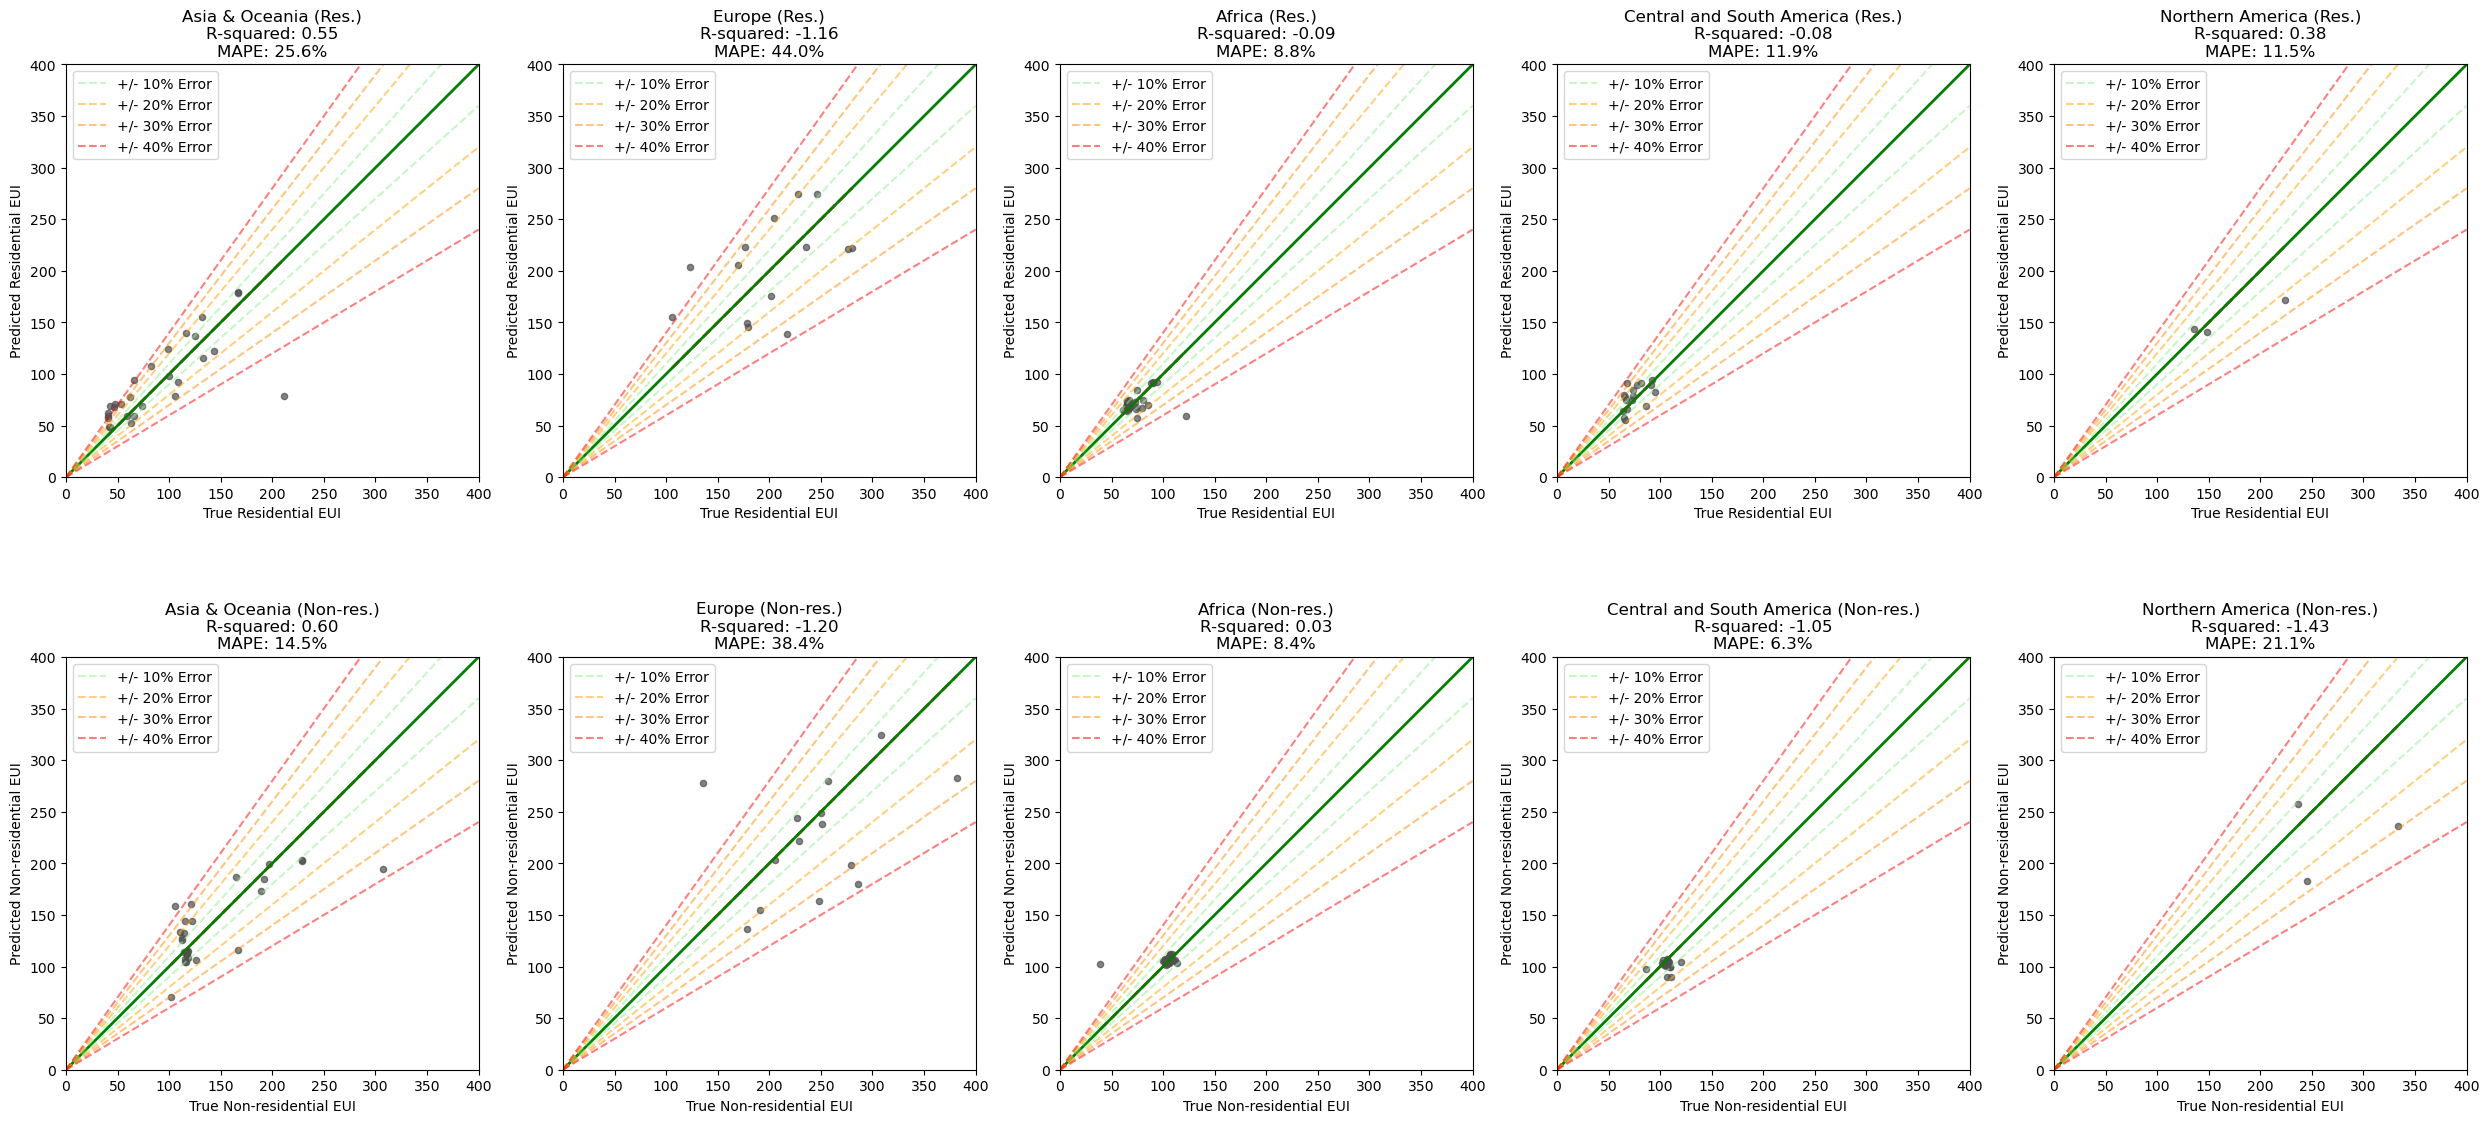

In [8]:
# Prepare the plot
fig, axes = plt.subplots(2, 5, figsize=(25, 12))  # 2 rows, 5 columns
axes = axes.flatten()

# Loop through each region and train models for both target variables
for i, region in enumerate(regions):
    region_df = merged_df[merged_df['Region Grouped'] == region]
    X_train = region_df[region_df['is_train'] == 1][features]
    X_test = region_df[region_df['is_train'] == 0][features]
    y_train_res = region_df[region_df['is_train'] == 1]['Residential EUI (kWh/m2/year)']
    y_test_res = region_df[region_df['is_train'] == 0]['Residential EUI (kWh/m2/year)']
    y_train_non_res = region_df[region_df['is_train'] == 1]['Non-residential EUI (kWh/m2/year)']
    y_test_non_res = region_df[region_df['is_train'] == 0]['Non-residential EUI (kWh/m2/year)']

    # Train the linear regression model for Residential EUI
    model_res = LinearRegression()
    model_res.fit(X_train, y_train_res)
    y_pred_res = model_res.predict(X_test)
    mse_res = mean_squared_error(y_test_res, y_pred_res)
    r2_res = r2_score(y_test_res, y_pred_res)
    mae_res = mean_absolute_error(y_test_res, y_pred_res)
    # Calculate MAPE for residential
    mape_res = np.mean(np.abs((y_test_res - y_pred_res) / y_test_res)) * 100

    # Train the linear regression model for Non-residential EUI
    model_non_res = LinearRegression()
    model_non_res.fit(X_train, y_train_non_res)
    y_pred_non_res = model_non_res.predict(X_test)
    mse_non_res = mean_squared_error(y_test_non_res, y_pred_non_res)
    r2_non_res = r2_score(y_test_non_res, y_pred_non_res)
    mae_non_res = mean_absolute_error(y_test_non_res, y_pred_non_res)
    # Calculate MAPE for non-residential
    mape_non_res = np.mean(np.abs((y_test_non_res - y_pred_non_res) / y_test_non_res)) * 100

    # Filter valid points where predictions and actual values are >= 0
    valid_res = (y_test_res >= 0) & (y_pred_res >= 0)
    y_test_res_valid = y_test_res[valid_res]
    y_pred_res_valid = y_pred_res[valid_res]

    valid_non_res = (y_test_non_res >= 0) & (y_pred_non_res >= 0)
    y_test_non_res_valid = y_test_non_res[valid_non_res]
    y_pred_non_res_valid = y_pred_non_res[valid_non_res]

    # Calculate the errors as 10%, 20%, 30%, and 40% margins
    error_10_res = y_pred_res_valid * 0.10
    error_20_res = y_pred_res_valid * 0.20
    error_30_res = y_pred_res_valid * 0.30
    error_40_res = y_pred_res_valid * 0.40

    error_10_non_res = y_pred_non_res_valid * 0.10
    error_20_non_res = y_pred_non_res_valid * 0.20
    error_30_non_res = y_pred_non_res_valid * 0.30
    error_40_non_res = y_pred_non_res_valid * 0.40

    # Plot for Residential EUI with error bands
    axes[i].scatter(y_test_res_valid, y_pred_res_valid, alpha=0.7, s=20, color="#4F4F4F")
    axes[i].plot([y_test_res_valid.min(), y_test_res_valid.max()], [y_test_res_valid.min(), y_test_res_valid.max()], 'r--', lw=2)
    axes[i].plot([0, 400], [0, 400], 'g-', lw=2)  # Add line x = y starting from 0, 0 to 400, 400
    axes[i].set_xlabel('True Residential EUI')
    axes[i].set_ylabel('Predicted Residential EUI')
    #axes[i].set_title(f'{region} (Res.)\nR-squared: {r2_res:.2f}\nMSE: {mse_res:.2f}\nMAE: {mae_res:.2f}\nMAPE: {mape_res:.1f}%')
    axes[i].set_title(f'{region} (Res.)\nR-squared: {r2_res:.2f}\nMAPE: {mape_res:.1f}%')


    # Add error bands as lines for Residential EUI
    x = np.linspace(0, 400, 401)

    axes[i].plot(x, x * (1 + 0.10), '--', color='lightgreen', alpha=0.5, label='+/- 10% Error')
    axes[i].plot(x, x * (1 - 0.10), '--', color='lightgreen', alpha=0.5)
    axes[i].plot(x, x * (1 + 0.20), '--', color='orange', alpha=0.5, label='+/- 20% Error')
    axes[i].plot(x, x * (1 - 0.20), '--', color='orange', alpha=0.5)
    axes[i].plot(x, x * (1 + 0.30), '--', color='darkorange', alpha=0.5, label='+/- 30% Error')
    axes[i].plot(x, x * (1 - 0.30), '--', color='darkorange', alpha=0.5)
    axes[i].plot(x, x * (1 + 0.40), '--', color='red', alpha=0.5, label='+/- 40% Error')
    axes[i].plot(x, x * (1 - 0.40), '--', color='red', alpha=0.5)

    # Set axis limits for Residential EUI
    axes[i].set_xlim(0, 400)
    axes[i].set_ylim(0, 400)
    axes[i].set_aspect('equal', adjustable='box')  # Maintain equal aspect ratio

    # Add legend for Residential EUI error bands
    axes[i].legend(loc='upper left')

    # Plot for Non-residential EUI with error bands
    axes[i + 5].scatter(y_test_non_res_valid, y_pred_non_res_valid, alpha=0.7, s=20, color='#4F4F4F')
    axes[i + 5].plot([y_test_non_res_valid.min(), y_test_non_res_valid.max()], [y_test_non_res_valid.min(), y_test_non_res_valid.max()], 'r--', lw=2)
    axes[i + 5].plot([0, 400], [0, 400], 'g-', lw=2)   
    axes[i + 5].set_xlabel('True Non-residential EUI')
    axes[i + 5].set_ylabel('Predicted Non-residential EUI')
    #axes[i + 5].set_title(f'{region} (Non-res.)\nR-squared: {r2_non_res:.2f}\nMSE: {mse_non_res:.2f}\nMAE: {mae_non_res:.2f}\nMAPE: {mape_non_res:.1f}%')
    axes[i + 5].set_title(f'{region} (Non-res.)\nR-squared: {r2_non_res:.2f}\nMAPE: {mape_non_res:.1f}%')

    # Add error bands as lines for Non-residential EUI
    axes[i + 5].plot(x, x * (1 + 0.10), '--', color='lightgreen', alpha=0.5, label='+/- 10% Error')
    axes[i + 5].plot(x, x * (1 - 0.10), '--', color='lightgreen', alpha=0.5)
    axes[i + 5].plot(x, x * (1 + 0.20), '--', color='orange', alpha=0.5, label='+/- 20% Error')
    axes[i + 5].plot(x, x * (1 - 0.20), '--', color='orange', alpha=0.5)
    axes[i + 5].plot(x, x * (1 + 0.30), '--', color='darkorange', alpha=0.5, label='+/- 30% Error')
    axes[i + 5].plot(x, x * (1 - 0.30), '--', color='darkorange', alpha=0.5)
    axes[i + 5].plot(x, x * (1 + 0.40), '--', color='red', alpha=0.5, label='+/- 40% Error')
    axes[i + 5].plot(x, x * (1 - 0.40), '--', color='red', alpha=0.5)

    # Set axis limits for Non-residential EUI
    axes[i + 5].set_xlim(0, 400)
    axes[i + 5].set_ylim(0, 400)
    axes[i + 5].set_aspect('equal', adjustable='box')  # Maintain equal aspect ratio

    # Add legend for Non-residential EUI error bands
    axes[i + 5].legend(loc='upper left')

plt.tight_layout()
fig.savefig('../figures/eui_predictions_within_domain.png', dpi=300, bbox_inches='tight')

plt.show()

# Experiment: LR - Cross Domain 

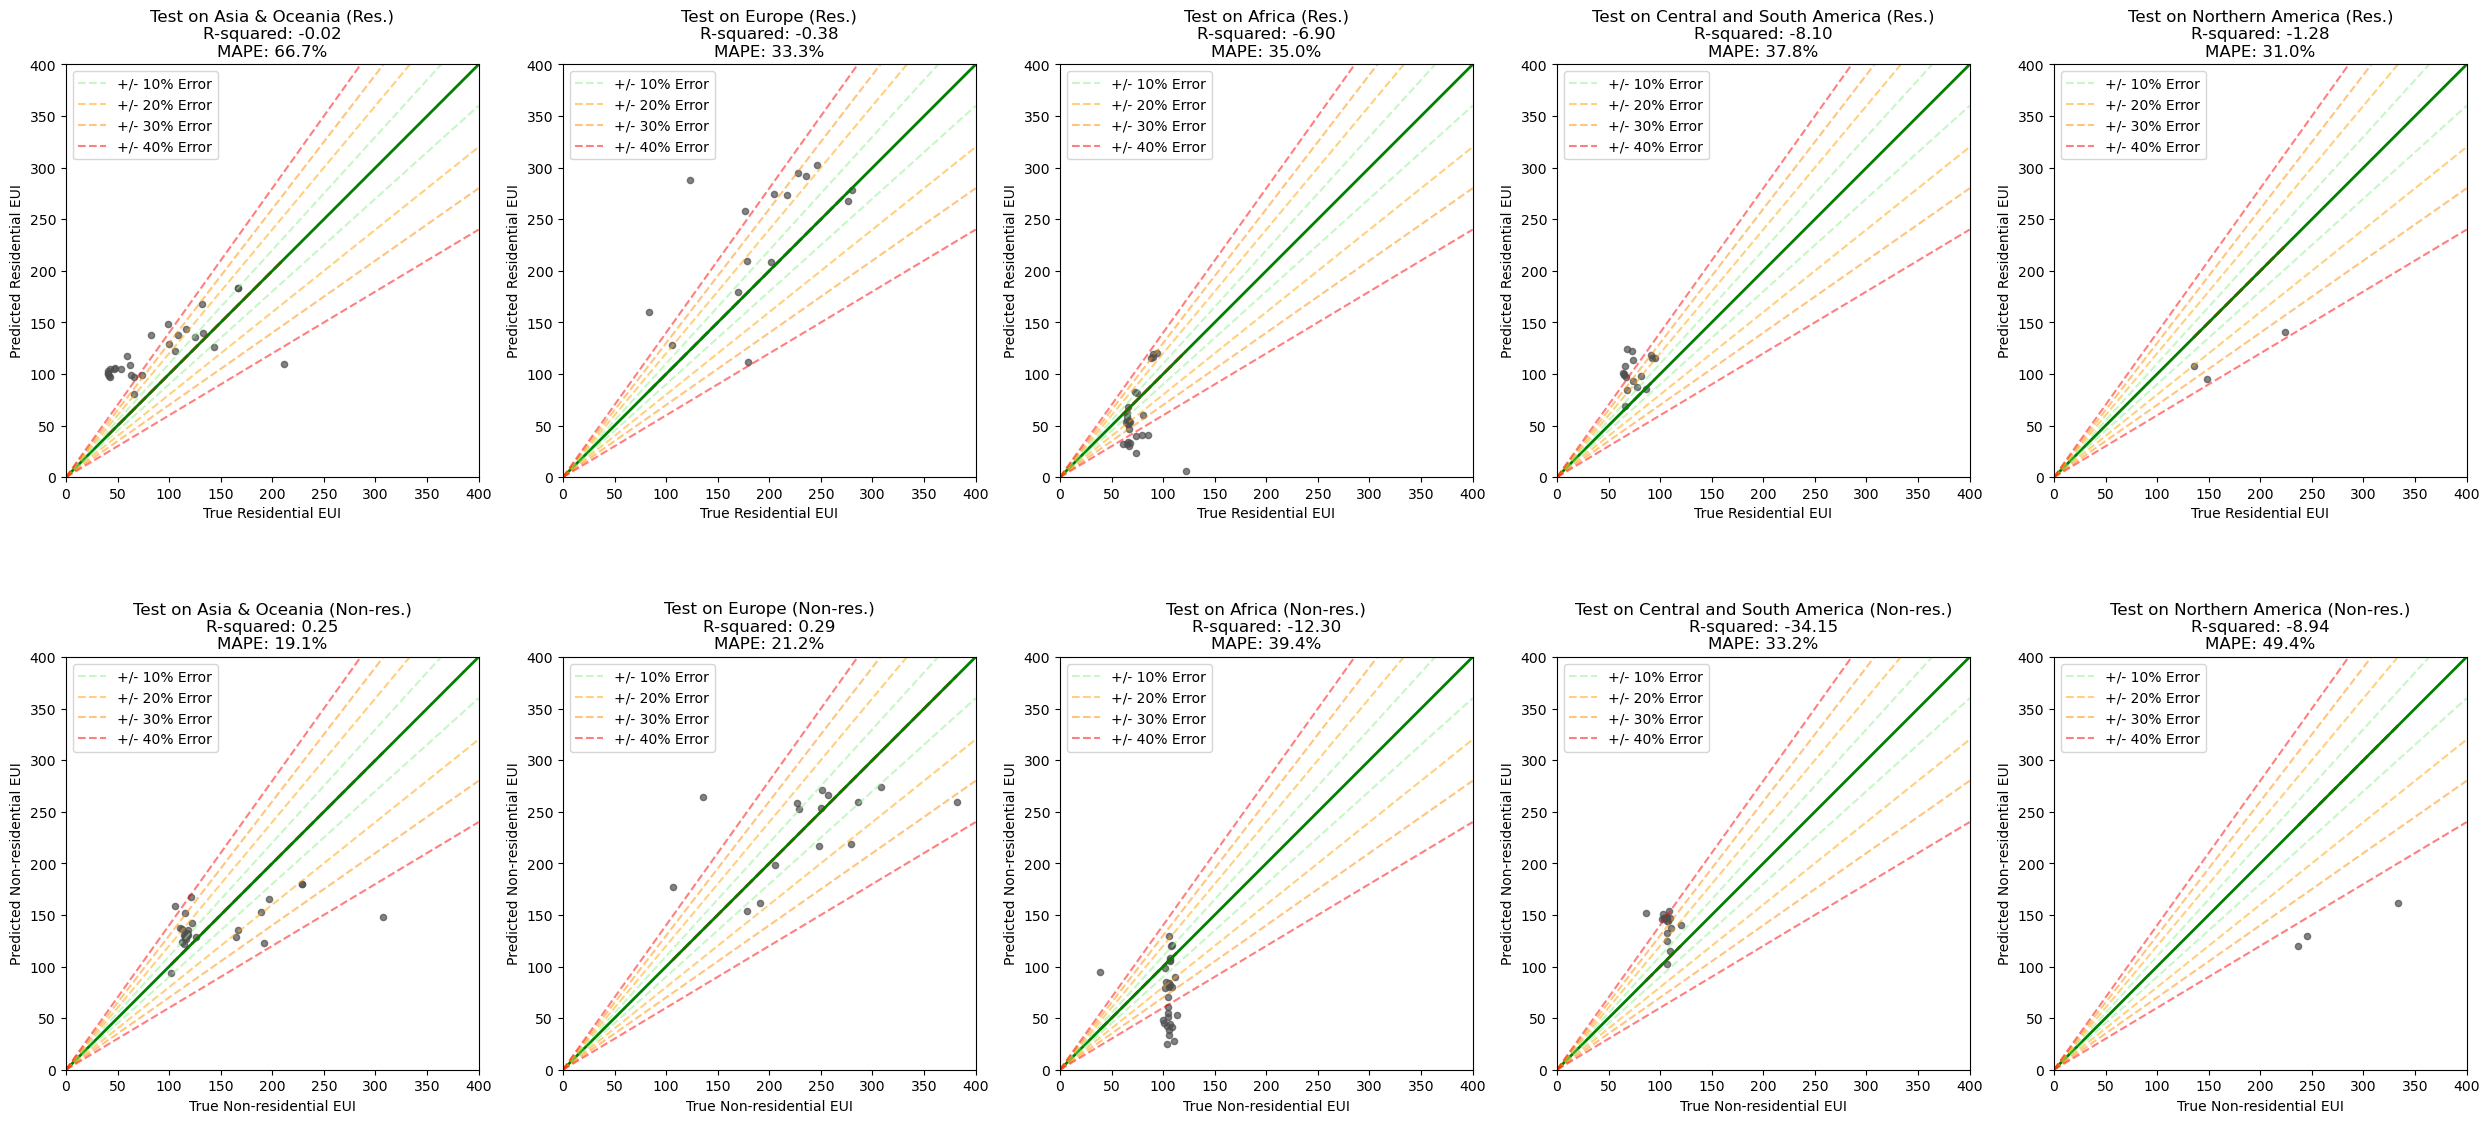

In [9]:
# Prepare the plot
fig, axes = plt.subplots(2, 5, figsize=(25, 12))  # 2 rows, 5 columns
axes = axes.flatten()

# Loop through each region as test set
for i, test_region in enumerate(regions):
    # Get training data: 80% of other regions
    train_df = merged_df[(merged_df['Region Grouped'] != test_region) & 
                        (merged_df['is_train'] == 1)]
    
    # Get test data: 20% of test region
    test_df = merged_df[(merged_df['Region Grouped'] == test_region) & 
                       (merged_df['is_train'] == 0)]
    
    # Prepare features and targets
    X_train = train_df[features]
    y_train_res = train_df['Residential EUI (kWh/m2/year)']
    y_train_non_res = train_df['Non-residential EUI (kWh/m2/year)']
    
    X_test = test_df[features]
    y_test_res = test_df['Residential EUI (kWh/m2/year)']
    y_test_non_res = test_df['Non-residential EUI (kWh/m2/year)']

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate residential model
    model_res = LinearRegression()
    model_res.fit(X_train_scaled, y_train_res)
    y_pred_res = model_res.predict(X_test_scaled)
    
    # Calculate metrics for residential
    r2_res = r2_score(y_test_res, y_pred_res)
    mape_res = np.mean(np.abs((y_test_res - y_pred_res) / y_test_res)) * 100

    # Train and evaluate non-residential model
    model_non_res = LinearRegression()
    model_non_res.fit(X_train_scaled, y_train_non_res)
    y_pred_non_res = model_non_res.predict(X_test_scaled)
    
    # Calculate metrics for non-residential
    r2_non_res = r2_score(y_test_non_res, y_pred_non_res)
    mape_non_res = np.mean(np.abs((y_test_non_res - y_pred_non_res) / y_test_non_res)) * 100

    # Filter valid points
    valid_res = (y_test_res >= 0) & (y_pred_res >= 0)
    y_test_res_valid = y_test_res[valid_res]
    y_pred_res_valid = y_pred_res[valid_res]

    valid_non_res = (y_test_non_res >= 0) & (y_pred_non_res >= 0)
    y_test_non_res_valid = y_test_non_res[valid_non_res]
    y_pred_non_res_valid = y_pred_non_res[valid_non_res]

    # Plot for Residential EUI
    axes[i].scatter(y_test_res_valid, y_pred_res_valid, alpha=0.7, s=20, color="#4F4F4F")
    axes[i].plot([y_test_res_valid.min(), y_test_res_valid.max()], 
                 [y_test_res_valid.min(), y_test_res_valid.max()], 'r--', lw=2)
    axes[i].plot([0, 400], [0, 400], 'g-', lw=2)
    axes[i].set_xlabel('True Residential EUI')
    axes[i].set_ylabel('Predicted Residential EUI')
    axes[i].set_title(f'Test on {test_region} (Res.)\nR-squared: {r2_res:.2f}\nMAPE: {mape_res:.1f}%')
    
    # Add error bands
    x = np.linspace(0, 400, 401)
    for pct, color, label in zip([0.1, 0.2, 0.3, 0.4], 
                                ['lightgreen', 'orange', 'darkorange', 'red'],
                                ['+/- 10% Error', '+/- 20% Error', '+/- 30% Error', '+/- 40% Error']):
        axes[i].plot(x, x * (1 + pct), '--', color=color, alpha=0.5, label=label)
        axes[i].plot(x, x * (1 - pct), '--', color=color, alpha=0.5)

    # Set axis limits and aspect ratio for Residential
    axes[i].set_xlim(0, 400)
    axes[i].set_ylim(0, 400)
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].legend(loc='upper left')

    # Plot for Non-residential EUI
    axes[i + 5].scatter(y_test_non_res_valid, y_pred_non_res_valid, alpha=0.7, s=20, color='#4F4F4F')
    axes[i + 5].plot([y_test_non_res_valid.min(), y_test_non_res_valid.max()],
                     [y_test_non_res_valid.min(), y_test_non_res_valid.max()], 'r--', lw=2)
    axes[i + 5].plot([0, 400], [0, 400], 'g-', lw=2)
    axes[i + 5].set_xlabel('True Non-residential EUI')
    axes[i + 5].set_ylabel('Predicted Non-residential EUI')
    axes[i + 5].set_title(f'Test on {test_region} (Non-res.)\nR-squared: {r2_non_res:.2f}\nMAPE: {mape_non_res:.1f}%')

    # Add error bands for Non-residential
    for pct, color, label in zip([0.1, 0.2, 0.3, 0.4],
                                ['lightgreen', 'orange', 'darkorange', 'red'],
                                ['+/- 10% Error', '+/- 20% Error', '+/- 30% Error', '+/- 40% Error']):
        axes[i + 5].plot(x, x * (1 + pct), '--', color=color, alpha=0.5, label=label)
        axes[i + 5].plot(x, x * (1 - pct), '--', color=color, alpha=0.5)

    # Set axis limits and aspect ratio for Non-residential
    axes[i + 5].set_xlim(0, 400)
    axes[i + 5].set_ylim(0, 400)
    axes[i + 5].set_aspect('equal', adjustable='box')
    axes[i + 5].legend(loc='upper left')

plt.tight_layout()
fig.savefig('../figures/eui_predictions_cross_domain.png', dpi=300, bbox_inches='tight')
plt.show()

# Experiment: LR - All Domain 

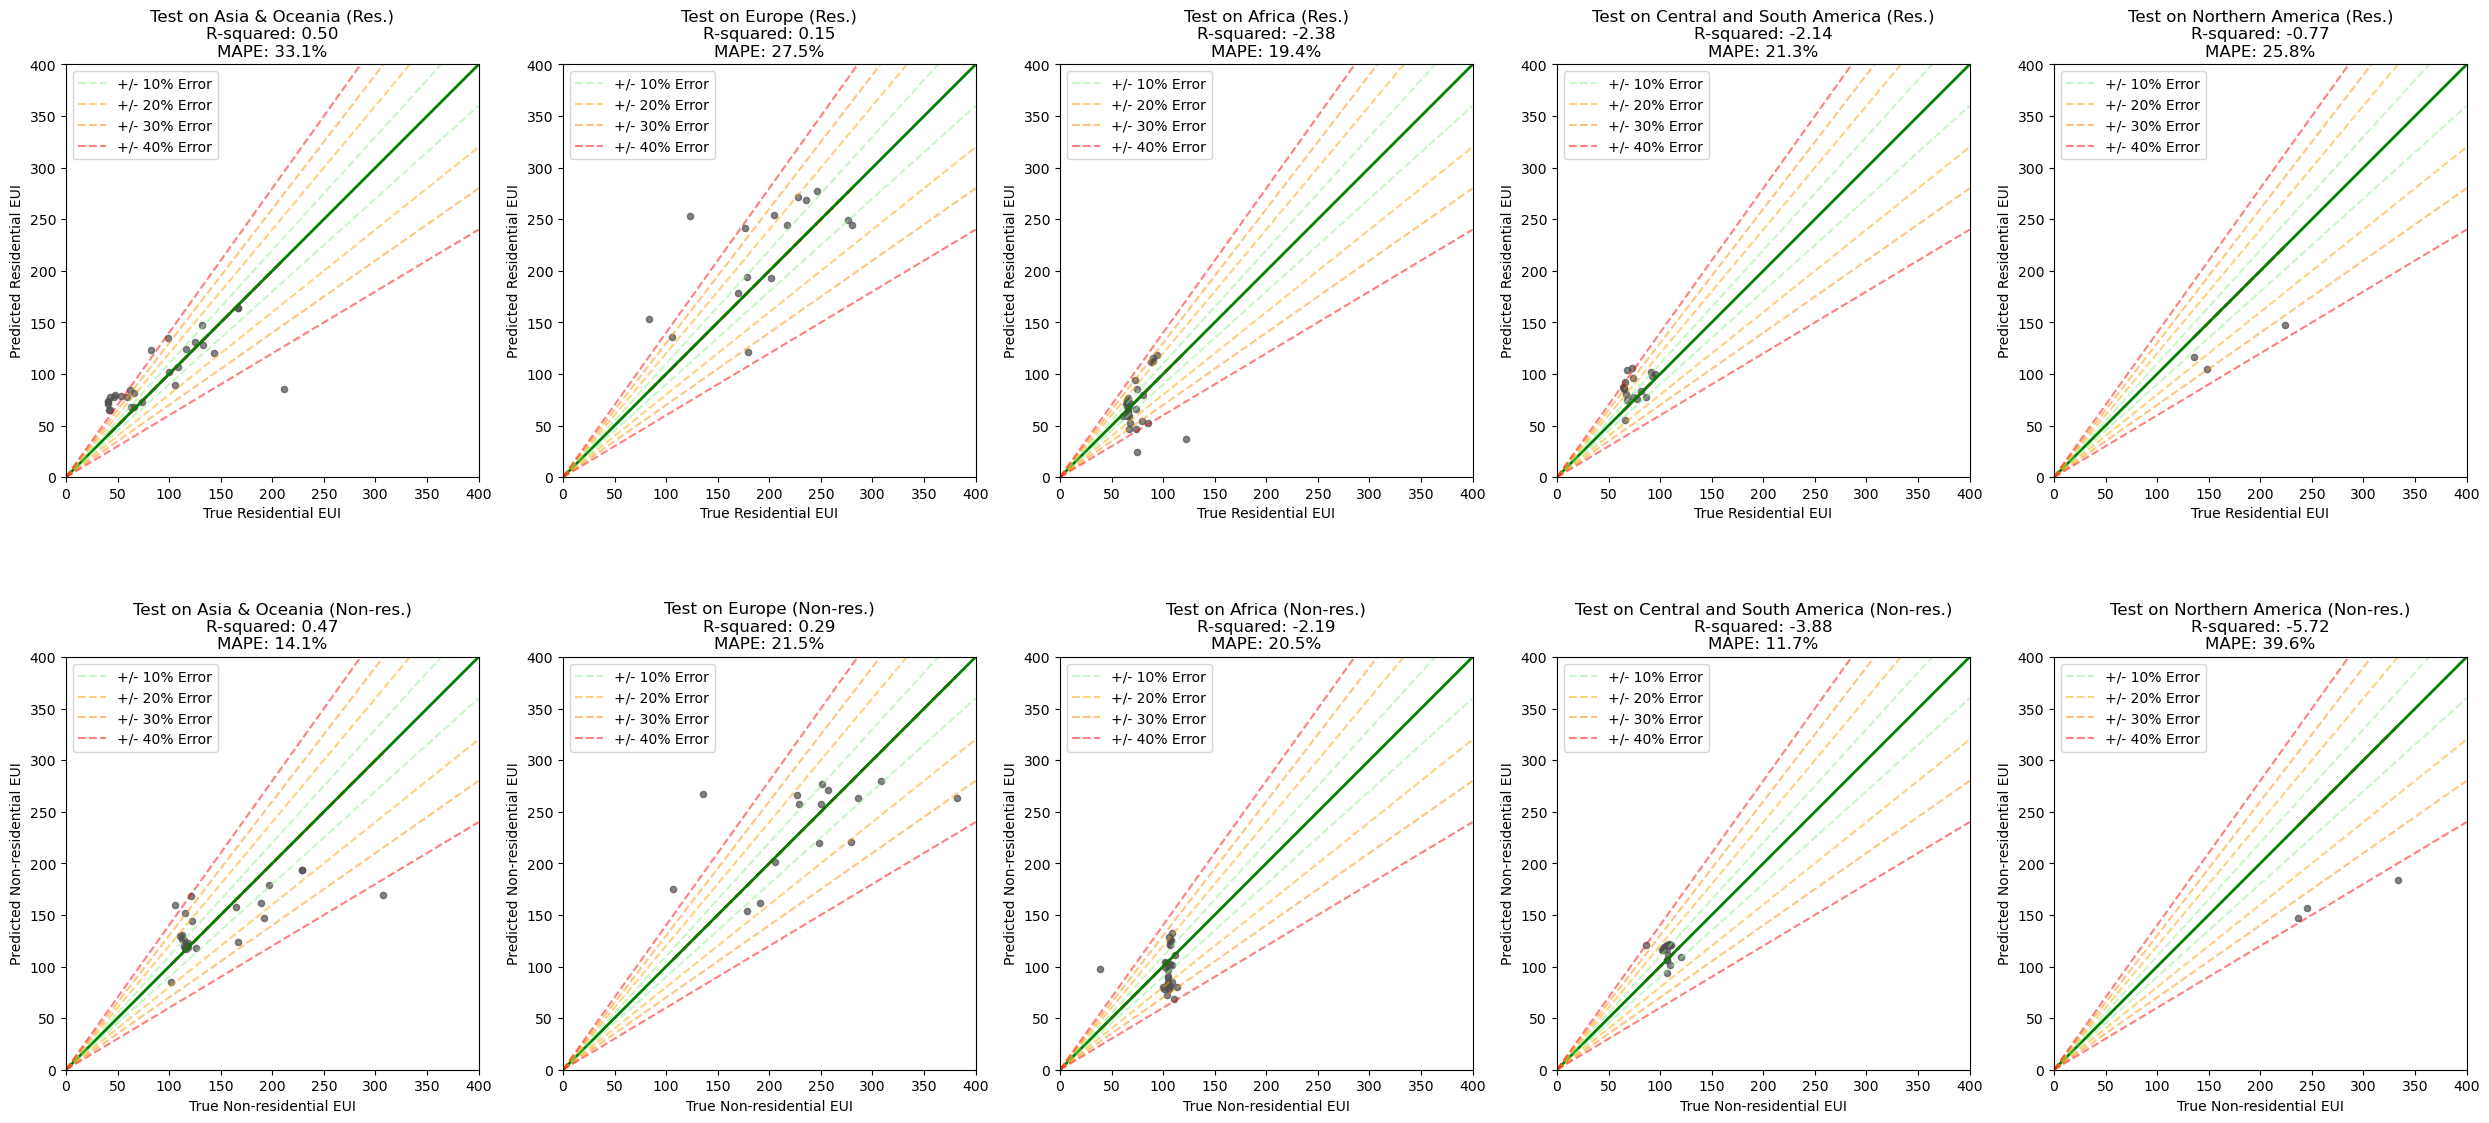

In [10]:
# Prepare the plot
fig, axes = plt.subplots(2, 5, figsize=(25, 12))  # 2 rows, 5 columns
axes = axes.flatten()

# Get all training data (80% from all regions)
train_df = merged_df[merged_df['is_train'] == 1]
X_train = train_df[features]
y_train_res = train_df['Residential EUI (kWh/m2/year)']
y_train_non_res = train_df['Non-residential EUI (kWh/m2/year)']

# Scale features for training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train models once with all training data
model_res = LinearRegression()
model_non_res = LinearRegression()
model_res.fit(X_train_scaled, y_train_res)
model_non_res.fit(X_train_scaled, y_train_non_res)

# Loop through each region for testing
for i, test_region in enumerate(regions):
    # Get test data (20% from the current region)
    test_df = merged_df[(merged_df['Region Grouped'] == test_region) & 
                       (merged_df['is_train'] == 0)]
    
    X_test = test_df[features]
    y_test_res = test_df['Residential EUI (kWh/m2/year)']
    y_test_non_res = test_df['Non-residential EUI (kWh/m2/year)']
    
    # Scale test data
    X_test_scaled = scaler.transform(X_test)
    
    # Make predictions
    y_pred_res = model_res.predict(X_test_scaled)
    y_pred_non_res = model_non_res.predict(X_test_scaled)
    
    # Calculate metrics
    r2_res = r2_score(y_test_res, y_pred_res)
    mape_res = np.mean(np.abs((y_test_res - y_pred_res) / y_test_res)) * 100
    
    r2_non_res = r2_score(y_test_non_res, y_pred_non_res)
    mape_non_res = np.mean(np.abs((y_test_non_res - y_pred_non_res) / y_test_non_res)) * 100

    # Filter valid points
    valid_res = (y_test_res >= 0) & (y_pred_res >= 0)
    y_test_res_valid = y_test_res[valid_res]
    y_pred_res_valid = y_pred_res[valid_res]

    valid_non_res = (y_test_non_res >= 0) & (y_pred_non_res >= 0)
    y_test_non_res_valid = y_test_non_res[valid_non_res]
    y_pred_non_res_valid = y_pred_non_res[valid_non_res]

    # Plot for Residential EUI
    axes[i].scatter(y_test_res_valid, y_pred_res_valid, alpha=0.7, s=20, color="#4F4F4F")
    axes[i].plot([y_test_res_valid.min(), y_test_res_valid.max()], 
                 [y_test_res_valid.min(), y_test_res_valid.max()], 'r--', lw=2)
    axes[i].plot([0, 400], [0, 400], 'g-', lw=2)
    axes[i].set_xlabel('True Residential EUI')
    axes[i].set_ylabel('Predicted Residential EUI')
    axes[i].set_title(f'Test on {test_region} (Res.)\nR-squared: {r2_res:.2f}\nMAPE: {mape_res:.1f}%')
    
    # Add error bands
    x = np.linspace(0, 400, 401)
    for pct, color, label in zip([0.1, 0.2, 0.3, 0.4], 
                                ['lightgreen', 'orange', 'darkorange', 'red'],
                                ['+/- 10% Error', '+/- 20% Error', '+/- 30% Error', '+/- 40% Error']):
        axes[i].plot(x, x * (1 + pct), '--', color=color, alpha=0.5, label=label)
        axes[i].plot(x, x * (1 - pct), '--', color=color, alpha=0.5)

    # Set axis limits and aspect ratio for Residential
    axes[i].set_xlim(0, 400)
    axes[i].set_ylim(0, 400)
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].legend(loc='upper left')

    # Plot for Non-residential EUI
    axes[i + 5].scatter(y_test_non_res_valid, y_pred_non_res_valid, alpha=0.7, s=20, color='#4F4F4F')
    axes[i + 5].plot([y_test_non_res_valid.min(), y_test_non_res_valid.max()],
                     [y_test_non_res_valid.min(), y_test_non_res_valid.max()], 'r--', lw=2)
    axes[i + 5].plot([0, 400], [0, 400], 'g-', lw=2)
    axes[i + 5].set_xlabel('True Non-residential EUI')
    axes[i + 5].set_ylabel('Predicted Non-residential EUI')
    axes[i + 5].set_title(f'Test on {test_region} (Non-res.)\nR-squared: {r2_non_res:.2f}\nMAPE: {mape_non_res:.1f}%')

    # Add error bands for Non-residential
    for pct, color, label in zip([0.1, 0.2, 0.3, 0.4],
                                ['lightgreen', 'orange', 'darkorange', 'red'],
                                ['+/- 10% Error', '+/- 20% Error', '+/- 30% Error', '+/- 40% Error']):
        axes[i + 5].plot(x, x * (1 + pct), '--', color=color, alpha=0.5, label=label)
        axes[i + 5].plot(x, x * (1 - pct), '--', color=color, alpha=0.5)

    # Set axis limits and aspect ratio for Non-residential
    axes[i + 5].set_xlim(0, 400)
    axes[i + 5].set_ylim(0, 400)
    axes[i + 5].set_aspect('equal', adjustable='box')
    axes[i + 5].legend(loc='upper left')

plt.tight_layout()
fig.savefig('../figures/eui_predictions_all_domain.png', dpi=300, bbox_inches='tight')
plt.show()